In [21]:
from myAE import SDC_AE
import torch
from torch import nn

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(784, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        z_1 = self.activation(self.l0(x))
        z_2 = self.activation(self.l1(z_1))
        z = self.l2(z_2)
        return z, z_1[:, ::256], z_2[:, ::256]


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(514, 512)
        self.l2 = nn.Linear(514, 784)

    def forward(self, z, z_1, z_2):
        o_1 = self.activation(self.l0(z))
        t_1 = torch.cat([o_1, z_1], dim=1)
        o_2 = self.activation(self.l1(t_1))
        t_2 = torch.cat([o_2, z_2], dim=1)
        x_hat = torch.sigmoid(self.l2(t_2))
        return x_hat

In [22]:
manager = SDC_AE()
manager.prepare_data()
manager.set_model(My_Encoder(2), My_Decoder(2))
print(manager.model)

Sequential(
  (encoder): My_Encoder(
    (l0): Linear(in_features=784, out_features=512, bias=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (l2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): My_Decoder(
    (l0): Linear(in_features=2, out_features=512, bias=True)
    (l1): Linear(in_features=514, out_features=512, bias=True)
    (l2): Linear(in_features=514, out_features=784, bias=True)
  )
)


In [23]:
def calc_loss(model, x, y, F, device):
  z, z_1, z_2 = model.get_submodule("encoder")(x)
  x_hat = model.get_submodule("decoder")(z, z_1, z_2)
  
  dist = z.norm(dim=1).sum()/len(x)
  recon = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
  loss = recon + dist
  return loss

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:1.


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


<AxesSubplot:xlabel='x', ylabel='y'>

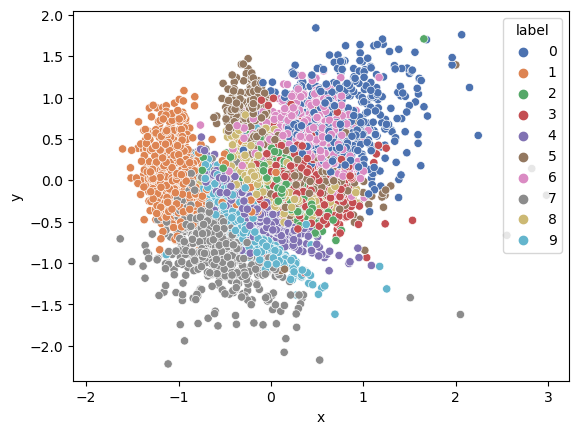

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(columns=['x', 'y', 'label'])

manager.model.to('cpu')
manager.model.eval()
with torch.no_grad():
  idx = 0
  for x, y in manager.train_dataloader:
    x = x.reshape([-1, 28*28])
    zs = manager.model.get_submodule('encoder')(x)
    
    tmp = pd.DataFrame(
      {
        'x': zs[0][:, 0],
        'y': zs[0][:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

In [25]:
# make hash table
manager.model.to('cpu')
manager.model.eval()

table = torch.zeros(60000, 3, 2)
idx = 0
with torch.no_grad():
  for x, y in manager.train_dataloader:
    x = x.reshape([-1, 28*28])
    z, z_1, z_2 = manager.model.get_submodule('encoder')(x)
    for jdx in range(len(z)):
      table[idx*len(z) + jdx][0] = z[jdx]
      table[idx*len(z) + jdx][1] = z_1[jdx]
      table[idx*len(z) + jdx][2] = z_2[jdx]
    

tensor([[-1.0000e+00, -1.0000e+00],
        [-8.0000e-01, -1.0000e+00],
        [-6.0000e-01, -1.0000e+00],
        [-4.0000e-01, -1.0000e+00],
        [-2.0000e-01, -1.0000e+00],
        [-1.4901e-08, -1.0000e+00],
        [ 2.0000e-01, -1.0000e+00],
        [ 4.0000e-01, -1.0000e+00],
        [ 6.0000e-01, -1.0000e+00],
        [ 8.0000e-01, -1.0000e+00],
        [ 1.0000e+00, -1.0000e+00]])
tensor([  1, 103,  60,  56,  70,  49,  72,  64,  84, 124, 128])
tensor([[[-1.0299, -0.4306],
         [-0.2438, -0.3301],
         [-0.2092,  0.8770]],

        [[-0.8991, -0.2187],
         [ 0.5736, -0.0046],
         [ 0.9508,  0.4343]],

        [[-0.7673, -0.7640],
         [-0.1149, -0.3948],
         [-0.4112,  0.8776]],

        [[-0.6929, -0.2078],
         [-0.5142, -0.8308],
         [ 0.5356,  0.2475]],

        [[-0.5957, -0.2144],
         [-0.3175, -0.3672],
         [-0.0281,  0.2006]],

        [[ 0.0434, -0.8720],
         [ 0.5647, -0.3339],
         [ 0.4204, -0.2998]],

     

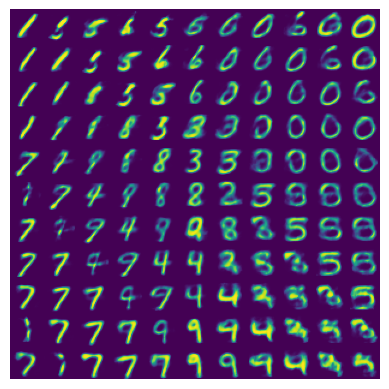

In [26]:
import matplotlib.pyplot as plt

grid_x, grid_y = torch.meshgrid(torch.linspace(-1, 1, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    args = (torch.stack([table[:, 0]]*len(r), dim=2).view(-1, len(r), 2) - r).norm(dim=2).argmin(dim=0)
    sample_z_1 = table[args][:, 1]
    sample_z_2 = table[args][:, 2]
    print(r)
    print(args)
    print(table[args])
    tmps = decoder(r, sample_z_1, sample_z_2).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(manager.model.get_submodule('decoder'), points)
  

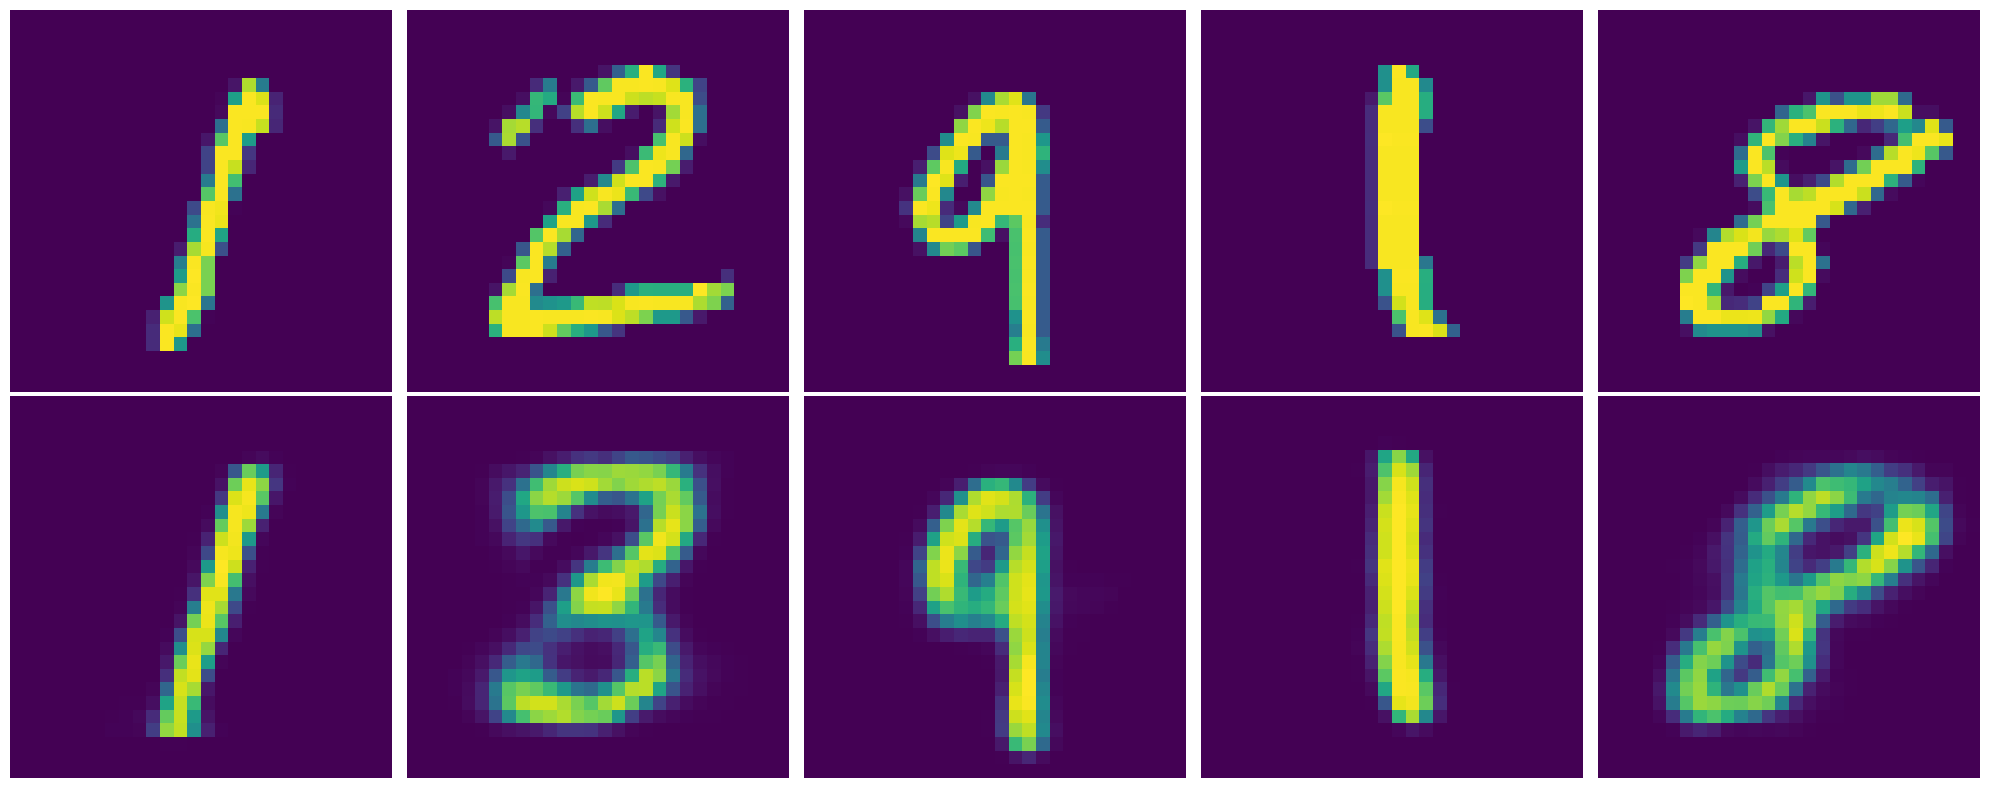

In [27]:
manager.model.to('cpu')
manager.model.eval()

with torch.no_grad():
  for x, y in manager.train_dataloader:
    x = x.reshape([-1, 28*28])
    z, z_1, z_2 = manager.model.get_submodule("encoder")(x)
    z = z + torch.randn_like(z) * 1e-2
    x_hat = manager.model.get_submodule("decoder")(z, z_1, z_2)
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, ncols=5, figsize=[20, 8])
    for idx, ax in enumerate(ax_1):
      ax.imshow(x[idx].view(28, 28))
      ax.axis('off')
    for idx, ax in enumerate(ax_2):
      ax.imshow(x_hat[idx].view(28, 28))
      ax.axis('off')
    break
plt.tight_layout()

In [66]:
sample_z = torch.randn(3, 2)
# (torch.stack([table[:, 0]]*3, dim=2).view(-1, 3, 2) - sample_z).norm(dim=2).argmax(dim=1)
args = (torch.stack([table[:, 0]]*3, dim=2).view(-1, 3, 2) - sample_z).norm(dim=2).argmax(dim=0)
sample_z_1 = table[args][:, 1]
sample_z_1

tensor([[ 0.1225,  0.5700],
        [ 0.1225,  0.5700],
        [-0.5777, -0.7901]])

In [55]:
torch.stack([table[:, 0]]*3, dim=2)[0]

tensor([[-4.5497, -4.5497, -4.5497],
        [ 0.6260,  0.6260,  0.6260]])

In [41]:
(table[:, 0] - points[0]).shape

RuntimeError: The size of tensor a (60000) must match the size of tensor b (11) at non-singleton dimension 0